## HT Correction V2
Fixing minor errors in the subfunctions written from V1. Realizing that using change in tail position as a marker for HT errors is not accurate. After manually lining up the actual video with our EDA plots from V1, there were many cases where a HT swap occurs but the change in tail position was below our defined threshold. 

While I was manually watching videos of larva, I noticed that everytime an error occured it was always before the larva "blinks." In this case, a "blink" is when the head, tail, and centroid coordinates all converge into the centroid position. In the next version, I attempt to use this as a marker for finding errors. 

In [4]:
import numpy as np
import sys
np.set_printoptions(threshold=sys.maxsize)
from numpy import diff
import pandas as pd
import matplotlib.pyplot as plt
from numpy import *

In [5]:
# original data
data = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data_processed.csv') 

In [15]:
# Filtering processed data
Xcentroid = pd.Series(data['X-Centroid'])
Ycentroid = pd.Series(data['Y-Centroid'])
Xhead = pd.Series(data['X-Head'])
Yhead = pd.Series(data['Y-Head'])
Xtail = pd.Series(data['X-Tail'])
Ytail = pd.Series(data['Y-Tail'])
frame = pd.Series(data['Frame'])

In [9]:
# Function to find distance bewteen two frames
def dis(x1, y1, x2, y2):
    dist = (((x1-x2)**2 + (y1-y2)**2)**(1/2))
    return dist

In [10]:
# function to create change in tailPosition data
def tail_position_change(xt, yt, frame):
    tailPosition = []
    
    for i in range(frame[0]): # if frame doesn't start at 0
        tailPosition.append(0)
    
    for i in range(len(xt)-1):
        dist = dis(xt[i], yt[i], xt[i+1], yt[i+1])
        tailPosition.append(dist)
    
    return tailPosition

In [11]:
# function to make a plot for tailPosition data
def plot_tail_change(tail_data):
    xlist = np.linspace(frame[0], frame[0]+len(tail_data), len(tail_data)) # frames as x
    ylist = tail_data # change in tail position as y

    fig, ax = plt.subplots()
    ax.plot(xlist, ylist, linewidth=2.0)

    plt.show()

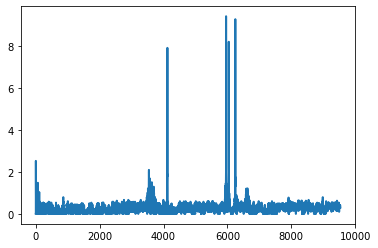

In [8]:
# create data and plot it
tchange = tail_position_change(Xtail, Ytail, frame)
tchange_plot = plot_tail_change(tchange)

In [9]:
# Find the peaks (relative max) 
peaks = (diff(sign(diff(tchange))) < 0).nonzero()[0] + 1 

# Find peaks greater than threshold (temporarily set at 4)
big_peaks = []
for frame in peaks:
    if tchange[frame] > 4:
        big_peaks.append(frame)
        
big_peaks

[4119, 5956, 6039, 6245]

In [1]:
# implementing function from Zainab's code to fix the segments where the HT makes an error 

# take in the file, the peak (array of peaks we need to check), 
def ht_correction(peak, xc, yc, xh, yh, xt, yt, frame):
    xheadCorrected = xh.copy()
    yheadCorrected = yh.copy()
    xtailCorrected = xt.copy()
    ytailCorrected = yt.copy()
    
    # plot change in tail position without corrections
    tchange = tail_position_change(xt, yt, frame)
    tchange_plot = plot_tail_change(tchange)
    
    # test for HT correction
    def ht_error_correction(fr1, fr2, j):
        d1 = dis(xc[fr1], yc[fr1], xc[fr2], yc[fr2])
        d2 = dis(xc[fr1], yc[fr1], xt[fr2], yt[fr2])
        
        if d1 < d2: # PROBLEM: need to find a specific point where the error ends 
            xheadCorrected[peak[j]:peak[j]+15] = xt[peak[j]:peak[j]+15]
            yheadCorrected[peak[j]:peak[j]+15] = yt[peak[j]:peak[j]+15]
            xtailCorrected[peak[j]:peak[j]+15] = xh[peak[j]:peak[j]+15]
            ytailCorrected[peak[j]:peak[j]+15] = yh[peak[j]:peak[j]+15]
            
            #print(xheadCorrected[fr1:fr2])
    
    for n in range(len(peak)):
        ht_error_correction(peak[n]-15, peak[n], n)
        #xheadCorrected = list(np.round(xheadCorrected,decimals = 1))
        #yheadCorrected = list(np.round(yheadCorrected, decimals=1))
        #xtailCorrected = list(np.round(xtailCorrected, decimals=1))
        #ytailCorrected = list(np.round(ytailCorrected, decimals=1))
    
    # plot change in tail position WITH corrections
    tchange1 = tail_position_change(xtailCorrected, ytailCorrected, frame)
    tchange_plot1 = plot_tail_change(tchange1)
    
    # finding peaks (if any) in the new set
    peaks = (diff(sign(diff(tchange1))) < 0).nonzero()[0] + 1
    
    new_peaks = []
    for frame in peaks:
        if tchange1[frame] > 4:
            new_peaks.append(frame)
        
    print(new_peaks)

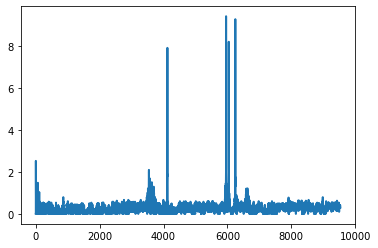

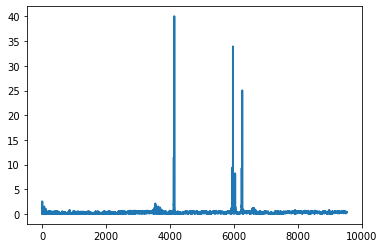

[4120, 4135, 5956, 5972, 6039, 6245, 6261]


In [15]:
# Call the function 
ht_correction(big_peaks, Xcentroid, Ycentroid, Xhead, Yhead, Xtail, Ytail, frame)

### DIFFERENT APPROACH
- try using the blinks (which can be detected from the unprocessed data) as markers to check whether a HT error occurered or not

In [12]:
# unprocessed data
up_data = pd.read_csv('2021.09.08_12-49-52_W1118_Solvent/2021.09.08_12-49-52_data.csv')

up_Xcentroid = pd.Series(up_data['X-Centroid'])
up_Ycentroid = pd.Series(up_data['Y-Centroid'])
up_Xhead = pd.Series(up_data['X-Head'])
up_Yhead = pd.Series(up_data['Y-Head'])
up_Xtail = pd.Series(up_data['X-Tail'])
up_Ytail = pd.Series(up_data['Y-Tail'])
up_frame = pd.Series(up_data['Frame'])

In [13]:
# Find all points when centroid = head = tail
flags = []
for i in range(len(up_Xcentroid)):
    if (up_Xcentroid[i] == up_Xhead[i] == up_Xtail[i] != 0) and (up_Ycentroid[i] == up_Yhead[i] == up_Ytail[i] != 0):
        flags.append(i)

# Attempting to remove the continuous points
proc_flags = []
for i in range(len(flags)-1):
    if flags[i+1] != flags[i] + 1:
        proc_flags.append(flags[i])

In [16]:
# Find all blinks that are actually errors 
error_flags = []
for i in proc_flags:
    if i < 2: 
        continue 
    
    # check one frame after and closest one before that is NOT in flags (problem)
    d1 = dis(Xtail[i-1], Ytail[i-1], Xtail[i+1], Ytail[i+1])
    d2 = dis(Xcentroid[i], Ycentroid[i], Xtail[i-1], Ytail[i-1])
    
    if d1 > d2:
        error_flags.append(i)

error_flags


[3543, 3561, 4118, 5957, 6036, 6038, 6633]

In [17]:
# Find all blinks that swap correctly
correct_flags = []
for i in proc_flags:
    if i < 2: 
        continue 
    
    # check one frame after and closest one before that is NOT in flags (problem)
    d1 = dis(Xhead[i-1], Yhead[i-1], Xhead[i+1], Yhead[i+1])
    d2 = dis(Xcentroid[i], Ycentroid[i], Xhead[i-1], Yhead[i-1])
    
    if d1 > d2:
        correct_flags.append(i)

correct_flags

[3666, 4118, 5957, 6036, 6038]